# Validation of method

### Table of contents

1. [**qSVGP**](#tsvgp)
2. [**tSVGP**](#qsvgp)
3. [**SSGP**](#ssgp)
4. [**STGP**](#stgp)



In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import sys
sys.path.append("..")


import jax
import jax.numpy as jnp
import jax.random as jr
from jax.nn import softplus

import optax

jax.config.update('jax_platform_name', 'cpu')
#jax.config.update('jax_disable_jit', True)
jax.config.update("jax_enable_x64", True)

#import os
#if not os.path.exists('./saves'):
#    os.makedirs('./saves')


import pickle


import lib


import matplotlib.pyplot as plt
plt.style.use(['../paper.mplstyle'])

/var/home/dl543/Documents/Learning/nonparametric-modulated-renewal/notebooks/../lib/inference.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [49]:
x_dims = 2
f_dims = x_dims
    
len_fx = 1.*np.ones((f_dims, x_dims))  # GP lengthscale
var_f = 0.01*np.ones(f_dims)  # observation noise
kern = lib.GP.kernels.SquaredExponential(f_dims, variance=var_f, lengthscale=len_fx)
mean_f = np.zeros(f_dims)
num_induc = 5
induc_locs = jax.random.normal(jax.random.PRNGKey(123), shape=(f_dims, num_induc, x_dims))

lambda_1 = 1.*jax.random.normal(jax.random.PRNGKey(123), shape=(f_dims, num_induc, 1))
chol_Lambda_2 = 10.*jnp.eye(num_induc)[None, ...].repeat(f_dims, axis=0)

dynamics_function = lib.GP.sparse.tSVGP(kern, mean_f, induc_locs, lambda_1, chol_Lambda_2, RFF_num_feats=1000)

chol_process_noise = 0. * jnp.eye(x_dims)
p0_mean = jnp.zeros((x_dims, 1))
p0_Lcov = jnp.eye(x_dims)

In [50]:
ts = 1000

As = jnp.eye(x_dims)[None, ...].repeat(ts, axis=0)
Qs = jnp.eye(x_dims)[None, ...].repeat(ts, axis=0)
H = jnp.zeros((1, x_dims)).at[0, 0].set(1.)
minf = jnp.zeros((x_dims,))
P0 = jnp.eye(x_dims)
site_obs = jnp.zeros((ts, x_dims, 1))
site_Lcov = .1 * jnp.eye(x_dims)[None, ...].repeat(ts, axis=0)

state_posterior = lib.GP.markovian.LGSSM(As, Qs, H, minf, P0, site_obs, site_Lcov)

In [51]:
p0_mean = jnp.zeros((x_dims, 1))
p0_Lcov = 1. * jnp.eye(x_dims)


gpssm = lib.GP.gpssm.DTGPSSM(dynamics_function, chol_process_noise, p0_mean, p0_Lcov, state_posterior)

In [52]:
prng_state = jr.PRNGKey(123)
num_samps = 5

prior_samps = gpssm.sample_prior(prng_state, num_samps, ts, jitter=1e-6)
post_samps = gpssm.sample_posterior(prng_state, num_samps, ts, jitter=1e-6)

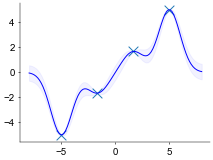

In [20]:
f_dim = 0
x_dim = 0
tr = 0

n_ps = qf_c.shape[-1]
#qf_v = qf_c[f_dim, tr, 0]
qf_v = qf_c[f_dim, tr, np.arange(n_ps), np.arange(n_ps)]
lb = qf_m[f_dim, tr, :, 0] - 1.96 * qf_v ** 0.5
ub = qf_m[f_dim, tr, :, 0] + 1.96 * qf_v ** 0.5
m = qf_m[f_dim, tr, :, 0]



plt.plot(xx[:, 0, x_dim], m, 'b', label='posterior mean')
plt.fill_between(xx[:, 0, x_dim], lb, ub, color='b', alpha=0.05, label='95% confidence')
#plt.plot(xx[:, 0, x_dim], qf_x[..., f_dim], alpha=0.3)
plt.scatter(x_obs[f_dim, :, x_dim], f_obs[f_dim, :, 0], marker='x', s=100)
plt.show()

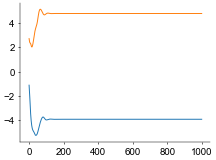

In [36]:
tr = 4

plt.plot(prior_samps[tr, :1000, 0])
plt.plot(prior_samps[tr, :1000, 1])

plt.show()

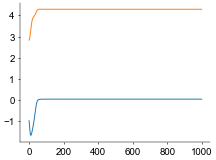

In [58]:
tr = 4

plt.plot(post_samps[tr, :1000, 0])
plt.plot(post_samps[tr, :1000, 1])

plt.show()

In [44]:
x = np.random.randn(1000)

def f(x):
    return 0.25*(10.*np.sin(x) - x**3)

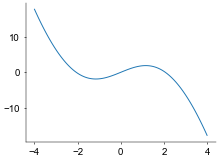

In [45]:
x_eval = np.linspace(-4., 4., 100)
y_eval = f(x_eval)

plt.plot(x_eval, y_eval)
plt.show()

In [54]:
ys = []
z = x
K = 5

for k in range(K):
    y = f(z)
    ys.append(y)
    z = y

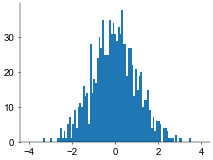

In [55]:
plt.hist(x, bins=np.linspace(-4., 4., 100))
plt.show()

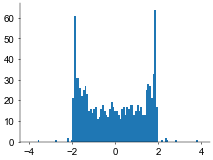

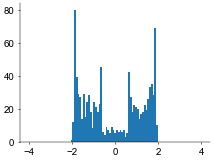

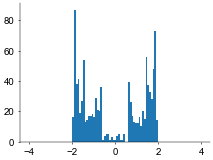

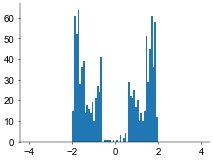

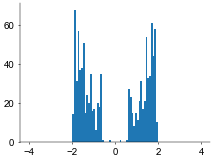

In [56]:
for k in range(K):
    plt.hist(ys[k], bins=np.linspace(-4., 4., 100))
    plt.show()